In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def exp_plat(ym, k, x):
    return ym * (1 - np.exp(-k * x))

EIR = np.linspace(1, 100, dtype=np.float32)
k = 3 * 1e-2
ym = .8
prev = exp_plat(ym, k, EIR)

In [3]:
sample_size = 5
EIR_sample = EIR[np.random.randint(0,len(EIR),sample_size)]

In [4]:
sigma = 0.05
def bounded(x, l, u):
    return np.minimum(np.maximum(x, l), u)

prev_sample = bounded(exp_plat(ym, k, EIR_sample) + np.random.normal(size=len(EIR_sample), scale=sigma), 0, 1).astype(np.float32)
pop_sample = np.maximum(np.random.normal(size=len(EIR_sample), loc=10000, scale=1000), 0.).astype(np.float32)

Text(0, 0.5, 'prev')

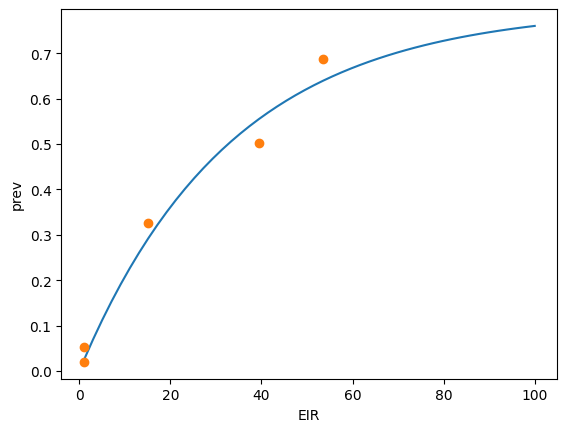

In [5]:
plt.plot(EIR, prev)
plt.plot(EIR_sample, prev_sample, 'o')
plt.xlabel('EIR')
plt.ylabel('prev')

In [6]:
import tensorflow_probability as tfp
tfd = tfp.distributions
from tensorflow.keras.models import load_model
import tensorflow as tf

2022-10-31 10:23:31.296010: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-31 10:23:31.457569: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
import matplotlib.pyplot as plt

In [8]:
model = load_model('./models/eq/')

2022-10-31 10:23:34.437374: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-31 10:23:35.355942: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38406 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:27:00.0, compute capability: 8.0
2022-10-31 10:23:35.357796: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38406 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:28:00.0, compute capability: 8.0


In [9]:
bounds = pd.read_csv('./outputs/eq/bounds.csv',dtype={'name': str, 'min': np.float32, 'max': np.float32})

In [10]:
default_params = pd.read_csv('default_params.csv')
default_dict = dict(default_params.itertuples(index=False))

In [11]:
clipper = tfp.bijectors.SoftClip(bounds['min'], bounds['max'], hinge_softness=1e-10)
pop_sample_tf = tf.constant(pop_sample)
@tf.function
def model_prev(eir):
    if len(eir.shape) == 1:
        eir = tf.expand_dims(eir, axis=1)
    sites = eir.shape[1]
    batch_size = eir.shape[0]
    X_ = tf.stack([default_dict[n] for n in bounds.name.iloc[1:]], axis=len(eir.shape) - 2)[tf.newaxis, :]
    X_ = tf.repeat(X_, (batch_size * sites), axis=0)
    eir_rep = tf.reshape(eir, (batch_size * sites, 1))
    X = tf.concat([eir_rep, X_], axis=1)
    prev_pred = model(clipper(X))
    return tf.reshape(prev_pred, (batch_size, sites))

@tf.function
def prob_prev(eir):
    prev_pred = model_prev(eir)
    return tfd.Independent(
        tfd.Binomial(total_count=pop_sample_tf[tf.newaxis, :], probs=prev_pred),
        reinterpreted_batch_ndims=1
    )

In [12]:
from collections import OrderedDict
EIR_sigma = 10
EIR_guesses = bounded(EIR_sample + np.random.normal(size=len(EIR_sample), scale=EIR_sigma).astype(np.float32), 0., 100.)

joint_dist = tfp.distributions.JointDistributionNamed(
    OrderedDict(
        eir = tfd.Independent(
            tfd.TruncatedNormal(loc=EIR_guesses, scale=np.full(sample_size, EIR_sigma, dtype=np.float32), low=0, high=100),
            reinterpreted_batch_ndims=1
        ),
        prev = lambda eir : prob_prev(eir)
    )
)

In [13]:
prior = joint_dist.sample(1000)

2022-10-31 10:23:43.295447: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


<Figure size 640x480 with 0 Axes>

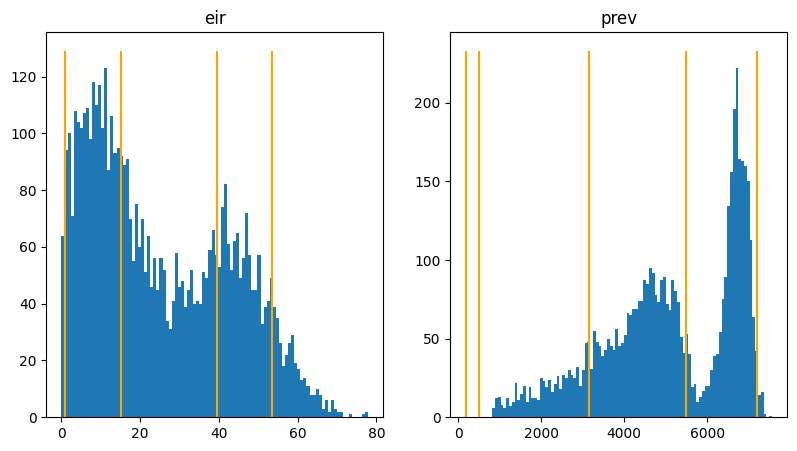

In [14]:
cols = 4
rows = (len(prior) // cols + 1)
prior_keys = list(prior.keys())
bounds_dict = { n: (l, u) for n, l, u in bounds.itertuples(index=False) }
plt.tight_layout()
fig, axes = plt.subplots(rows, cols, figsize=(cols * rows * 5, 5))
for c in range(cols):
    for r in range(rows):
        if len(axes.shape) == 1:
            ax = axes[c]
        else:
            ax = axes[r][c]
        if cols * r + c < len(prior_keys):
            k = prior_keys[cols * r + c]
            ax.hist(prior[k].numpy().flatten(), bins=100)
            if k in bounds_dict.keys():
                ax.vlines(bounds_dict[k], 0, ax.get_ylim()[1], color='orange')
            if k in default_dict.keys():
                ax.vlines(default_dict[k], 0, ax.get_ylim()[1], color='green')
            elif k == 'prev':
                ax.vlines(prev_sample * pop_sample, 0, ax.get_ylim()[1], color='orange')
            elif k == 'eir':
                ax.vlines(EIR_sample, 0, ax.get_ylim()[1], color='orange')
            ax.set_title(k)
        else:
            fig.delaxes(ax)

In [15]:
%%time
# Initialize the HMC transition kernel.
tf.config.experimental.enable_tensor_float_32_execution(False)
num_results = 500 #int(2 * 1e3)
num_burnin_steps = 0 #int(1e3)

num_chains = 10

observed_prev = tf.constant(pop_sample * prev_sample)
initial_state_dict = joint_dist.sample(num_chains)
initial_state_dict.pop('prev')
initial_state = list(initial_state_dict.values())

def log_prob(*state):
    #return prob_prev(state[0]).log_prob(observed_prev) # this ignores the prior distributions
    return joint_dist.log_prob(
        *state,
        observed_prev
    )

mcmc = tfp.mcmc.SimpleStepSizeAdaptation(
    inner_kernel = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=log_prob,
        num_leapfrog_steps=3,
        step_size=1.
    ),
    num_adaptation_steps=int((num_burnin_steps + num_results) * 0.8)
)

def run_chain():
    return tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=initial_state,
      parallel_iterations=num_chains,
      kernel=mcmc,
      trace_fn=lambda _, pkr: (pkr.inner_results.is_accepted, pkr.new_step_size)
    )

samples, (acceptance, step_size) = run_chain()

CPU times: user 1min 38s, sys: 2.77 s, total: 1min 41s
Wall time: 1min 33s


In [16]:
acceptance.numpy().mean()

0.0024

<Figure size 640x480 with 0 Axes>

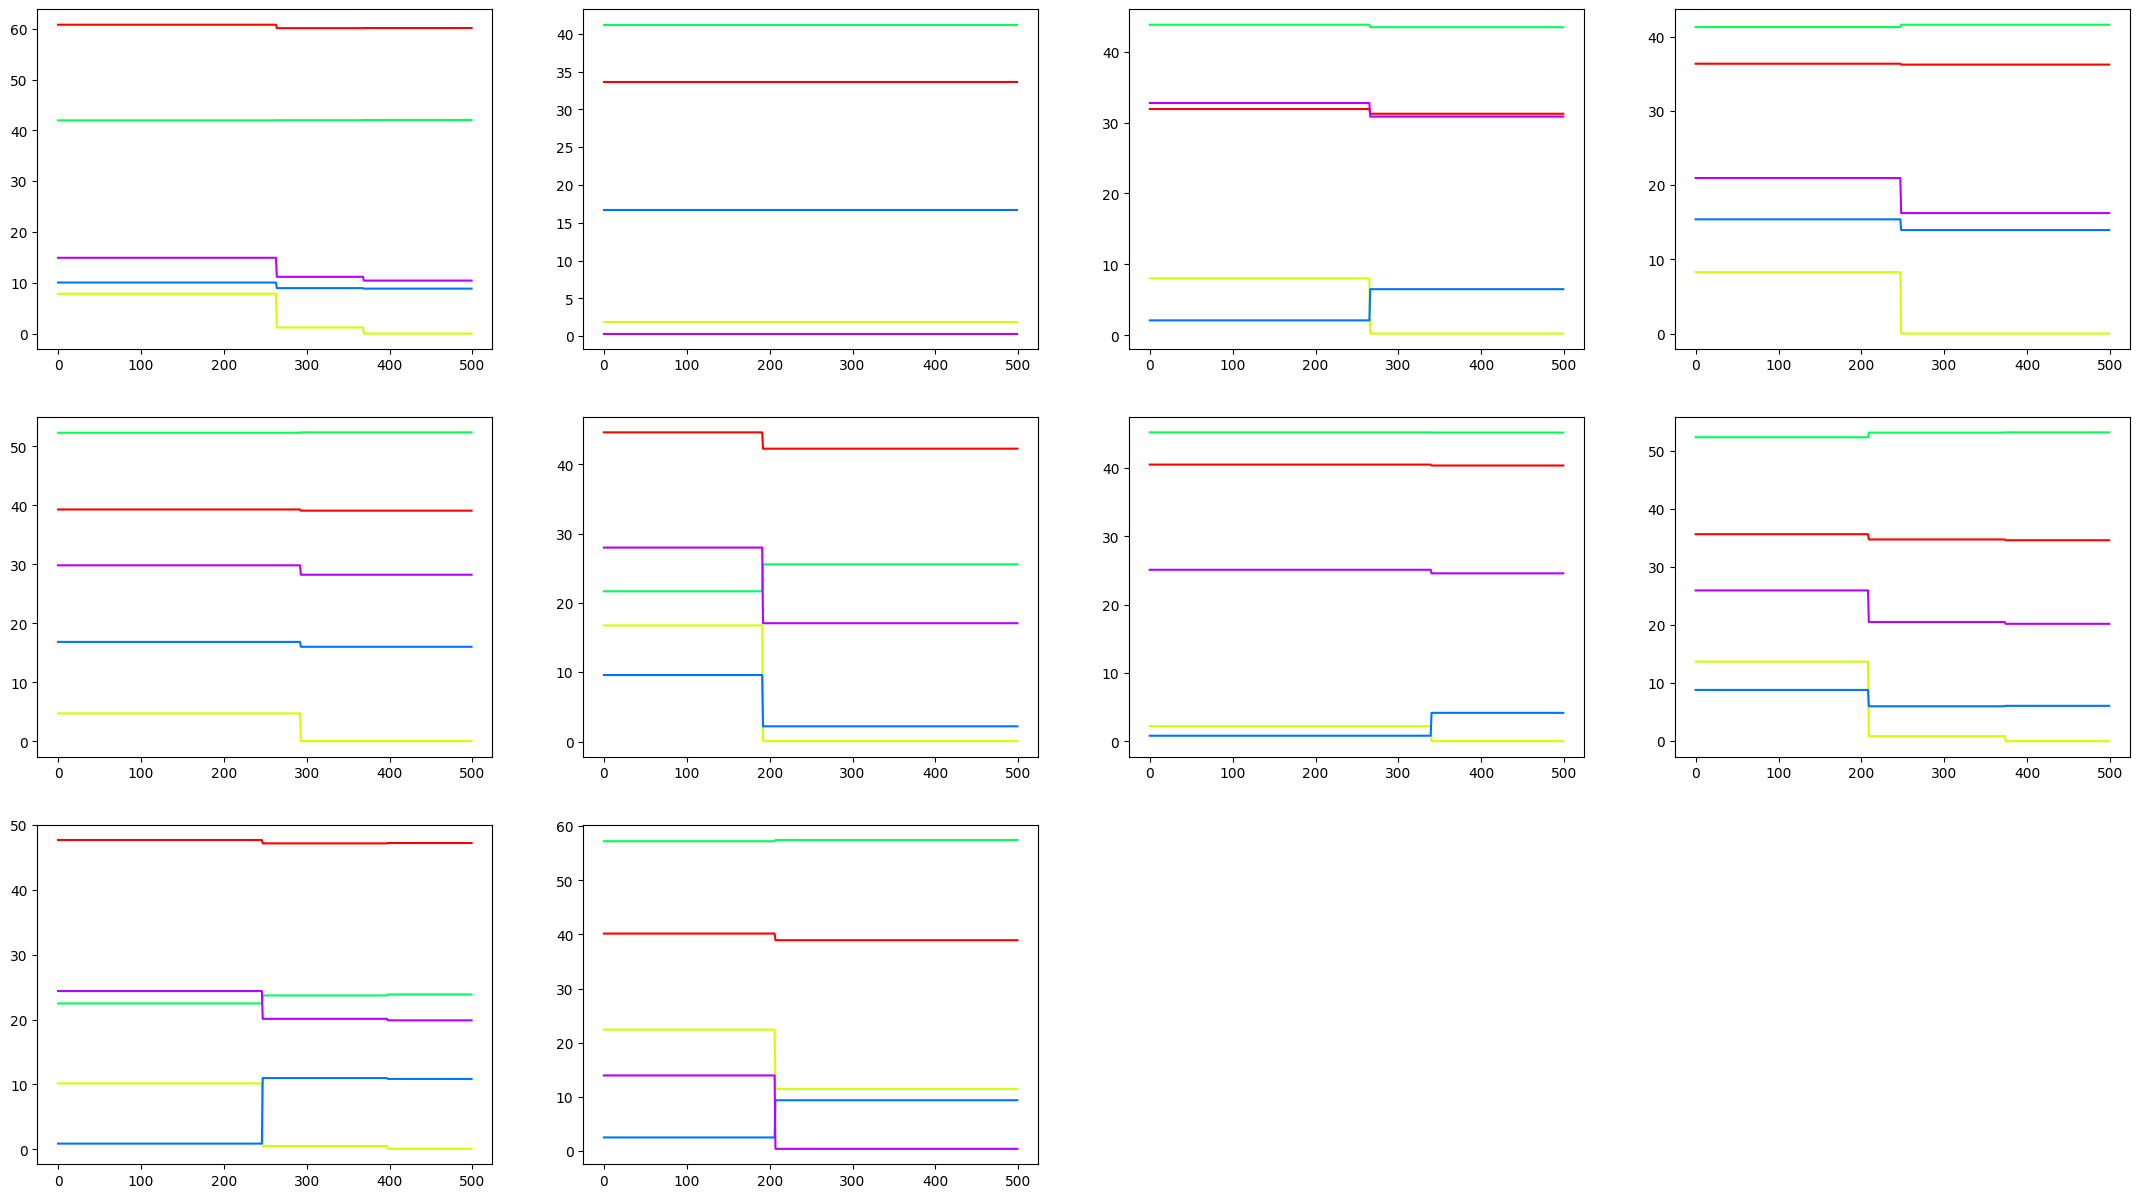

In [17]:
cols = 4
rows = (num_chains // cols + 1)
plt.tight_layout()
fig, axes = plt.subplots(rows, cols, figsize=(cols * rows + 15, 15))
for c in range(cols):
    for r in range(rows):
        if len(axes.shape) == 1:
            ax = axes[c]
        else:
            ax = axes[r][c]
        i = cols * r + c
        if i < num_chains:
            for s in range(samples[0].shape[2]):
                ax.plot(samples[0][:, i:i + 1, s], c=plt.cm.get_cmap('hsv')(s/5))
        else:
            fig.delaxes(ax)

In [18]:
posterior = dict(zip(initial_state_dict.keys(), samples))

<Figure size 640x480 with 0 Axes>

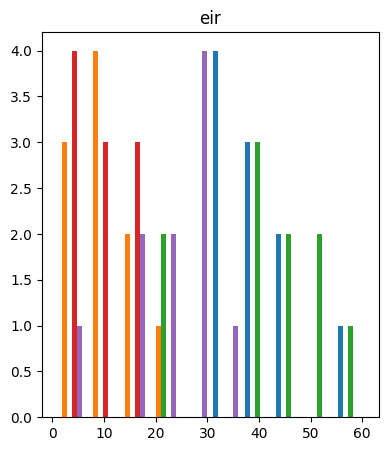

In [19]:
cols = 4
rows = (len(posterior) // cols + 1)
posterior_keys = list(posterior.keys())
bounds_dict = { n: (l, u) for n, l, u in bounds.itertuples(index=False) }
plt.tight_layout()
fig, axes = plt.subplots(rows, cols, figsize=(cols * rows * 5, 5))
for c in range(cols):
    for r in range(rows):
        if len(axes.shape) == 1:
            ax = axes[c]
        else:
            ax = axes[r][c]
        if cols * r + c < len(posterior_keys):
            k = posterior_keys[cols * r + c]
            ax.hist(posterior[k][0].numpy())
            if k in bounds_dict.keys():
                ax.vlines(bounds_dict[k], 0, ax.get_ylim()[1], color='orange')
            elif k == 'prev':
                ax.vlines(np.average(prev_sample * pop_sample), 0, ax.get_ylim()[1], color='orange')
            if k in default_dict.keys():
                ax.vlines(default_dict[k], 0, ax.get_ylim()[1], color='green')
            ax.set_title(k)
        else:
            fig.delaxes(ax)

(array([1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.]),
 array([  1.86066031,   5.34134817,   8.82203579,  12.30272388,
         15.78341198,  19.26409912,  22.74478722,  26.22547531,
         29.70616341,  33.1868515 ,  36.66753769,  40.14822769,
         43.62891388,  47.10960388,  50.59029007,  54.07097626,
         57.55166626,  61.03235245,  64.51303864,  67.99372864,
         71.47441864,  74.95510101,  78.43579102,  81.91648102,
         85.39717102,  88.87785339,  92.3585434 ,  95.8392334 ,
         99.31991577, 102.80060577, 106.28129578, 109.76198578,
        113.24266815, 116.72335815, 12

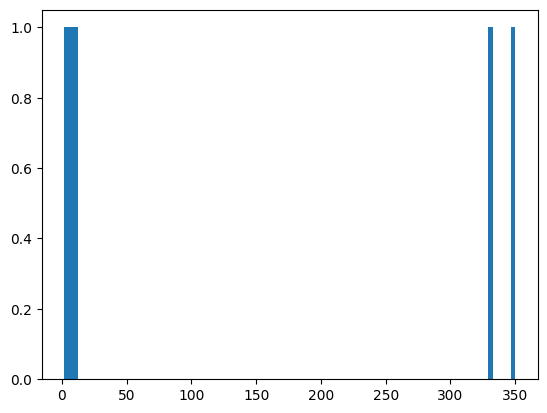

In [20]:
plt.hist(tfp.mcmc.potential_scale_reduction(samples), bins=100)

# TODO:

 * consider bijectors on kernel
 * retrain surrogate model on 0-100
 * translate fixes to all parameters